#Approach
LSTM Neural Networks, which stand for Long Short-Term Memory, these networks manage to keep contextual information of inputs by integrating a loop that allows information to flow from one step to the next. These loops make recurrent neural networks seem magical. LSTM predictions are always conditioned by the past experience of the network’s inputs.

Thus in the approach i have used a LSTM neural net with acombination of single layer convolution layer which is better for sequence classification.
First the text data is cleaned using NLTK internal libraries , then its get tokenized and padded and at the final stage it is fed to the neural net model.

##Importing Dependencies

In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from string import punctuation
from google.colab import files
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


####Downloading NLTK stop words

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

####Uploading files from desktop to Google Colab

In [3]:
file_name = files.upload()

Saving V1.4_Training.csv to V1.4_Training (12).csv
Saving SubtaskA_Trial_Test.csv to SubtaskA_Trial_Test (8).csv
Saving SubtaskA_Trial_Test_Labeled.csv to SubtaskA_Trial_Test_Labeled (12).csv
Saving SubtaskA_EvaluationData.csv to SubtaskA_EvaluationData (12).csv


## Loading the data

####Train Data

In [4]:
train_data = pd.read_csv('V1.4_Training.csv',header=None,names=['Id','Text','Classification'])
train_data.head(2)

,Id,Text,Classification
0,663_3,"""Please enable removing language code from the...",1
1,663_4,"""Note: in your .csproj file, there is a Suppor...",0


####Evaluation Data

In [5]:
eval_data = pd.read_csv('SubtaskA_EvaluationData.csv',header=None,names=['Id','sentence','Classification'])
eval_data.head(2)

,Id,sentence,Classification
0,9566,This would enable live traffic aware apps.,X
1,9569,Please try other formatting like bold italics ...,X


####Labelled test data

In [6]:
test_data = pd.read_csv('SubtaskA_Trial_Test_Labeled.csv',encoding='ISO-8859-1', engine='python' )
test_data.head(2)

,id,sentence,label
0,1310_1,I'm not asking Microsoft to Gives permission l...,1
1,1312_1,somewhere between Android and iPhone.,0


## Function to clean the text field from data

In [0]:
def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)

    ## Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    ## Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    
    
    tagged_text = nltk.tag.pos_tag(text.split())
    edited_text = [word for word,tag in tagged_text if tag not in ['NN','NNS','NNP','NNPS', 'FW']]
    text = " ".join(edited_text)

    return text

In [8]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

####Using lambda function to apply clean_text to training data

In [0]:
train_data['Text'] = train_data['Text'].map(lambda x: clean_text(x))

In [0]:
train_data = train_data.astype({'Classification': str})
train_data = train_data[train_data['Classification'].map(len)<2]

In [11]:
train_data.head(2)

,Id,Text,Classification
0,663_3,enabl remov exampl ever select ru - laguag pub...,1
1,663_4,: supportedcultur like this : de - - < publish...,0


In [12]:
train_data = train_data.iloc[:,1:3]
train_data.head(2)

,Text,Classification
0,enabl remov exampl ever select ru - laguag pub...,1
1,: supportedcultur like this : de - - < publish...,0


####Tokenizing and padding the training text data

In [0]:
vocabulary_size = 1000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(train_data['Text'])

sequences = tokenizer.texts_to_sequences(train_data['Text'])
data = pad_sequences(sequences, maxlen=50)

##Making and Compiling the Model

In [14]:
model = Sequential()
model.add(Embedding(vocabulary_size, 100, input_length=50))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))
    
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer='Adam',    metrics=['accuracy'])
    

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
#storing labels of training data in a variable
labels = train_data['Classification']

###Training the Model

In [16]:
trained_model = model.fit(data,np.array(labels),validation_split=0.2,epochs=10)

Instructions for updating:
Use tf.cast instead.
Train on 6800 samples, validate on 1700 samples
Epoch 1/10
6800/6800 [==============================] - 32s 5ms/step - loss: 0.4793 - acc: 0.7932 - val_loss: 0.4735 - val_acc: 0.7859
Epoch 2/10
6800/6800 [==============================] - 29s 4ms/step - loss: 0.3728 - acc: 0.8379 - val_loss: 0.4648 - val_acc: 0.7876
Epoch 3/10
6800/6800 [==============================] - 29s 4ms/step - loss: 0.3254 - acc: 0.8660 - val_loss: 0.5018 - val_acc: 0.7888
Epoch 4/10
6800/6800 [==============================] - 28s 4ms/step - loss: 0.2710 - acc: 0.8903 - val_loss: 0.4907 - val_acc: 0.8118
Epoch 5/10
6800/6800 [==============================] - 29s 4ms/step - loss: 0.2238 - acc: 0.9119 - val_loss: 0.5578 - val_acc: 0.8059
Epoch 6/10
6800/6800 [==============================] - 29s 4ms/step - loss: 0.1805 - acc: 0.9310 - val_loss: 0.6703 - val_acc: 0.7953
Epoch 7/10
6800/6800 [==============================] - 29s 4ms/step - loss: 0.1470 - acc: 0.9

###Loading the Unlabelled test data 
It is used for making the predictions and then comparing it with actuall labelled output for checking the model accuracy

In [17]:
original = pd.read_csv('SubtaskA_Trial_Test.csv',header=None,names=['Id','sentence','Classification'])
original.head(2)

,Id,sentence,Classification
0,13101,"""I'm not asking Microsoft to Gives permission ...",X
1,13121,"""somewhere between Android and iPhone.""",X


In [0]:

original.drop('Classification',axis=1,inplace=True,)

###Applying clean_text function to test data

In [0]:
original['sentence'] = original['sentence'].map(lambda x: clean_text(x))

In [0]:
# Tokenizing and padding the test data for further model prediction
sequences_new = tokenizer.texts_to_sequences(original['sentence'])
data_new = pad_sequences(sequences_new, maxlen=50)

###Predicting the classes on test_data

In [0]:
y_new = model.predict_classes(data_new)

In [22]:
test_data['prediction'] = y_new
test_data.head(2)

,id,sentence,label,prediction
0,1310_1,I'm not asking Microsoft to Gives permission l...,1,1
1,1312_1,somewhere between Android and iPhone.,0,0


###Score of predictions made by model on unlabelled test data and actual data

In [23]:
accuracy_score(test_data['label'], test_data['prediction'])

0.6706081081081081

##Now putting model on Evaluation Data

In [24]:
eval_data.head(5)

,Id,sentence,Classification
0,9566,This would enable live traffic aware apps.,X
1,9569,Please try other formatting like bold italics ...,X
2,9576,Since computers were invented to save time I s...,X
3,9577,Allow rearranging if the user wants to change ...,X
4,9579,Add SIMD instructions for better use of ARM NE...,X


In [0]:
# Dropping the Classification column from data
eval_data.drop('Classification',axis=1,inplace=True)

In [0]:
# Making copy of evaluation data so that original can be accessed later
eval_data_copy = eval_data.copy()

In [0]:
# Cleaning the Evaluation data for further prediction using clean_text function
eval_data_copy['sentence'] = eval_data_copy['sentence'].map(lambda x: clean_text(x))

In [0]:
# Tokenizing and padding the evaluation data
seq_eval = tokenizer.texts_to_sequences(eval_data_copy['sentence'])
data_eval = pad_sequences(seq_eval, maxlen=50)

###Making predictions on Evaluation data

In [0]:
y_eval = model.predict_classes(data_eval)

## Adding the predicted output with the original data in dataframe

In [30]:
eval_data['label'] = y_eval
eval_data.head(2)

,Id,sentence,label
0,9566,This would enable live traffic aware apps.,0
1,9569,Please try other formatting like bold italics ...,0


###Converting the DataFrame obtained to CSV format

In [0]:
eval_data.to_csv('Anurag_gandhi.csv', header=False, index=False)

###Downloading the CSV from google colab

In [0]:
files.download('Anurag_gandhi.csv')

#Visualisations

##Plotting model accuracy with number of epochs

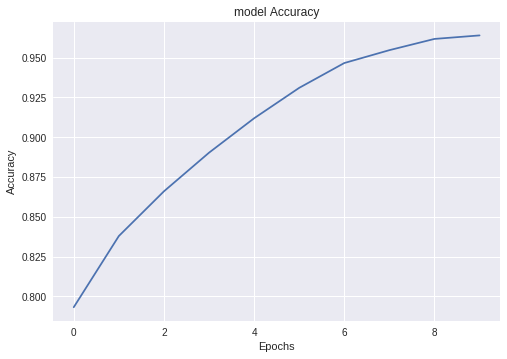

In [33]:
plt.plot(trained_model.history['acc'])
plt.title('model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

##Plotting training data loss and validation data loss

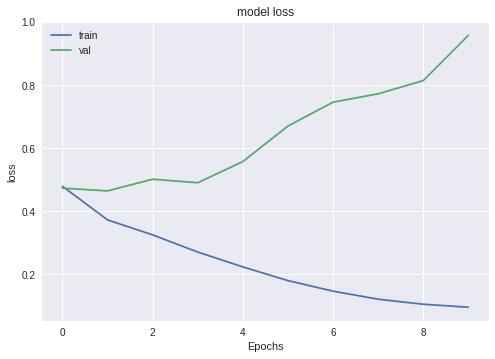

In [34]:
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='best')
plt.show()

###Plotting labels of training data

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


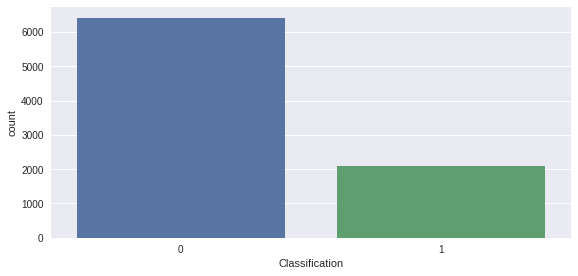

In [35]:
sns.factorplot('Classification',data= train_data,kind='count',aspect=2)
plt.show()

###Checking the plot of labels on predicted evaluation data

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


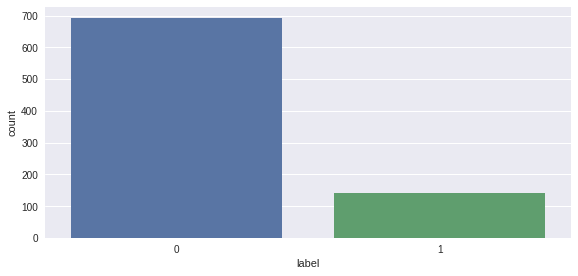

In [36]:
sns.factorplot('label',data= eval_data,kind='count',aspect=2)
plt.show()